# MODELLING CANADIAN HIGHWAYS VS. GERMAN HIGHWAYS

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from utils import decorate, savefig

**Driver Class, referenced from lab 10**

In [2]:
class Driver:
    def __init__(self, loc, speed=4):
        """Initialize the attributes.
        loc: position on track, in miles
        speed: speed in miles per hour
        change: var to check if driver wants to change lanes
        """
        self.start = loc
        self.loc = loc
        self.speed = speed
        
        #attributes defined to keep track of lanes
        self.change = 0
        self.lane = 0
        self.hold = 0
        
    def choose_acceleration(self, dist):
        """Chooses acceleration based on distance.
        dist: distance from the car in front
        returns: acceleration
        """
        return 1
    
    def set_odometer(self):
        self.start = self.loc
        
    def read_odometer(self):
        return self.loc - self.start

**Highway Class, referenced from lab 10**

In [3]:
from Cell2D import Cell2D

class Highway(Cell2D):
    
    max_acc = 1
    min_acc = -10
    """Arbitrarily high speed limit"""
    speed_limit = 130

    def __init__(self, n=10, lanes=2,length=1000, eps=0, constructor=Driver):
        """Initializes the attributes.
        n: number of drivers
        length: length of the track
        eps: variability in speed
        constructor: function used to instantiate drivers
        splits drivers across two lanes
        """
        
        #nested lists to seperate and identify drivers in each lane
        lane=[[],[]]
        drivers=[[],[]]
        self.length = length
        self.eps = eps
        self.crashes = 0
        for x in range (0,lanes):
            
            # dividing drivers equally in both lanes to start
            lane[x] = np.linspace(0, length, n//lanes, endpoint=False)
            locs = lane
            drivers[x] = [constructor(loc) for loc in locs[x]]
            # and link them up
            for i in range(n//lanes):
                j = (i+1) % (n//lanes)
                drivers[x][i].next = drivers[x][j]
                drivers[x][i].lane = x
                """self.drivers becomes a nested list, containing a list of drivers for each lane"""
            self.drivers=drivers

    def step(self):
        """Performs one time step."""
        for x in range (0,2):
            for driver in self.drivers[x]:
                self.move(driver)
            
    def move(self, driver):
        """Updates `driver`.
        
        driver: Driver object
        """
        # get the distance to the next driver
        dist = self.distance(driver)

        # let the driver choose acceleration
        # GWT: note that this is the only decision made by the driver.
        # The rest is left to the simulation.
        acc = driver.choose_acceleration(dist)
        acc = min(acc, self.max_acc)
        acc = max(acc, self.min_acc)
        speed = driver.speed + acc
            
        # add random noise to speed
        speed *= np.random.uniform(1-self.eps, 1+self.eps)
        
        # keep it nonnegative and under the speed limit
        speed = max(speed, 0)
        speed = min(speed, self.speed_limit)
        
        # if current speed would collide with next driver, stop
        if (driver.change == 1):
            self.change_lane(driver)
        if (speed > dist):
            speed = 0
            self.crashes += 1
            
        # update speed and loc
        driver.speed = speed
        driver.loc += speed
            
    def distance(self, driver):
        """Distance from `driver` to next driver.
        
        driver: Driver object
        """
        dist = driver.next.loc - driver.loc
        # fix wraparound
        if dist < 0:
            dist += self.length
        return dist
    
    def set_odometers(self):
        for x in range (0,2):
            return [driver.set_odometer()
                    for driver in self.drivers[x]] 
    
    def read_odometers(self):
        for x in range (0,2):
            return np.mean([driver.read_odometer()
                            for driver in self.drivers[x]])
    
    def draw(self):
        """Draws the drivers and shows collisions.
        """
        
        drivers = self.drivers
        xs, ys = self.get_coords(drivers)
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
                
        for x in range (0,2):
           
            if (x==0):
                plt.plot(xs[x], ys[x], 'bs', markersize=10, alpha=0.7)
                
            # smaller radius for inside lane and green driver markers
            if (x==1):
                plt.plot(xs[x]*0.85, ys[x]*0.85, 'gs', markersize=8, alpha=0.4)
            stopped = [driver for driver in self.drivers[x]
                      if driver.speed==0]
            xs[x], ys[x] = self.get_stopped_coords(stopped, r=0.8)
            if (x==0):
                plt.plot(xs[x]*1.1, ys[x]*1.1, 'r^', markersize=12, alpha=0.7)
                
            # yellow collision markers for inside lane
            if (x==1):
                plt.plot(xs[x]*0.7, ys[x]*0.7, 'y^', markersize=12, alpha=0.7)

            plt.axis('off')
            plt.axis('equal')
            plt.xlim([-1.05, 1.05])
            plt.ylim([-1.05, 1.05])

    def get_stopped_coords(self, drivers, r=1):
        """Gets the coordinates of the drivers.
        
        Transforms from (row, col) to (x, y).
        
        drivers: sequence of Driver
        r: radius of the circle
        
        returns: tuple of sequences, (xs, ys)
        """
        locs = np.array([driver.loc for driver in drivers])
        locs *= 2 * np.pi / self.length
        xs = r * np.cos(locs)
        ys = r * np.sin(locs)
        return xs, ys
    
    def get_coords(self, drivers,lanes=2, r=1):
        """Gets the coordinates of the drivers.
        
        Transforms from (row, col) to (x, y).
        
        drivers: sequence of Driver
        r: radius of the circle
        
        returns: tuple of sequences, (xs, ys)
        """
        locs=[[],[]]
        xs=[[],[]]
        ys=[[],[]]
        for x in range (lanes):
            locs[x] = np.array([driver.loc for driver in drivers[x]])
        
            locs[x] *= 2 * np.pi / self.length
            
            xs[x] = r * np.cos(locs[x])
            ys[x] = r * np.sin(locs[x])
        return xs, ys

    def change_lane(self, driver):
        drivers = self.drivers
        xs, ys = self.get_coords(drivers)
        for x in range (0,2):
            for y in range (0,len(drivers[x])-1):
                
                # find the driver thats switching lanes
                
                if (driver == drivers[x][y]):
                    
                    #if driver in lane 0
                    if(x==0):
                        
                        #if driver not at the end of the list
                        
                        if (y>0 and y<(len(drivers[1]))-1):
                            drivers[x][y-1].next = drivers[x][y+1]
                            drivers[1][y-1].next = drivers[x][y]
                            drivers[x][y].next = drivers[1][y+1]
                        
                        # if driver at the end of the list
                        else:
                            drivers[1][len(drivers[1])-1].next = drivers[x][y]
                        drivers[x][y].lane=1
                        drivers[1].append(drivers[x][y])
                        drivers[0].remove(drivers[x][y])
                    
                    # if driver in lane 1
                    
                    if(x==1):
                        
                        
                        #if driver not at the end of the list
                        
                        if (y>0 and y<(len(drivers[0]))-1):
                            drivers[x][y-1].next = drivers[x][y+1]
                            drivers[0][y-1].next = drivers[x][y]
                            drivers[x][y].next = drivers[0][y+1]
                        
                        #if driver at the end of the list
                        
                        else:
                            drivers[0][len(drivers[0])-1].next = drivers[x][y]
                        drivers[x][y].lane=0
                        drivers[0].append(drivers[x][y])
                        drivers[1].remove(drivers[x][y])


 **lets check functionality by defining an animation**

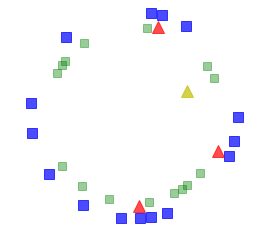

In [ ]:
# lets create a highway with 15 cars in each lane and animate
highway = Highway(30,lanes=2, eps=0.02)
highway.animate(frames=50, interval=0.2)

In [ ]:
# lets test the run simulation function referenced from lab 10. 
def run_simulation(eps, constructor=Driver, iters=100):
    res = []
    for n in range(5, 100, 5):
        highway = Highway(n, eps=eps, constructor=constructor)
        for i in range(iters):
            highway.step()

        highway.set_odometers()
        for i in range(iters):
            highway.step()

        res.append((n, highway.read_odometers() / iters))
    print (highway.crashes, "crashes reported with eps", eps)
    return np.transpose(res)

In [ ]:
np.random.seed(20)
from utils import set_palette
set_palette('Blues', 4, reverse=True)

for eps in [0.0, 0.001, 0.01]:
    xs, ys = run_simulation(eps)
    plt.plot(xs, ys, label='eps=%g' % eps)
    
decorate(xlabel='Number of cars',
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 110])


**Let's define a Canadian Driver class**

In [ ]:
class CanadianDriver(Driver):
    def choose_acceleration(self, d):
        #if under speed limit, and distance > speed. accelerate
        self.change = 0
        if (self.speed < 100) and (d > self.speed):
            if (self.speed + 10 > d):
                self.change = 1
                return 0
            return 1
        #if car infront, change lanes
        else:
            self.change = 1
            return 0

In [ ]:
def run_simulation(eps, constructor=CanadianDriver, iters=100):
    res = []
    for n in range(10, 100, 10):
        highway = Highway(n, eps=eps, constructor=constructor)
        for i in range(iters):
            highway.step()

        highway.set_odometers()
        for i in range(iters):
            highway.step()

        res.append((n, highway.read_odometers() / iters))
    print (highway.crashes, "crashes reported with eps", eps)
    
    return np.transpose(res)

In [ ]:
np.random.seed(20)
from utils import set_palette
set_palette('Blues', 4, reverse=True)

for eps in [0.0, 0.001, 0.01]:
    xs, ys = run_simulation(eps)
    plt.plot(xs, ys, label='eps=%g' % eps)
    
decorate(xlabel='Number of cars',
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 110])


In [ ]:
highway = Highway(30,lanes=2, eps=0.02, constructor=CanadianDriver)
highway.animate(frames=100, interval=0.2)

**Let's define a GermanDriver Class**

In [ ]:
class GermanDriver(Driver):
    
    def choose_acceleration(self, d):
        self.change = 0
        #if in right lane and space, accelerate
        if (self.speed <= 130) and (d > self.speed + 10) and (self.lane == 0):
            return 1
        #if right lane, and coming up on a vehicle, under speed limit, change lanes and accelerate
        elif (self.speed < 130) and (self.lane == 0) and (d < self.speed + 10):
            self.change = 1
            return 1
        #if in right lane and no space and at speed limit, change lanes 
        elif (self.speed == 130) and (self.lane == 0) and (d < self.speed + 20):
            self.change = 1
            return 0
        #if in left lane, give one unit of time to switch back
        if (self.lane == 1) and (self.hold < 1):
            self.hold += 1
            if (self.speed <= 130):
                return 1
            return 0
        elif (self.lane == 1) and (self.hold == 1):
            self.change = 1
            self.hold = 0
            return 0
        else:
            return 0

In [ ]:
def run_simulation(eps, constructor=GermanDriver, iters=100):
    res = []
    for n in range(10, 100, 10):
        highway = Highway(n, eps=eps, constructor=constructor)
        for i in range(iters):
            highway.step()

        highway.set_odometers()
        for i in range(iters):
            highway.step()

        res.append((n, highway.read_odometers() / iters))
    print (highway.crashes, "crashes reported with eps", eps)
    
    return np.transpose(res)

In [ ]:
from utils import set_palette
set_palette('Blues', 4, reverse=True)

for eps in [0.0, 0.001, 0.01]:
    xs, ys = run_simulation(eps)
    plt.plot(xs, ys, label='eps=%g' % eps)
    
decorate(xlabel='Number of cars',
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 110])


In [ ]:
highway = Highway(30,lanes=2, eps=0.02, constructor=GermanDriver)
highway.animate(frames=50, interval=0.2)